In [30]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
# import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [31]:
st_words = stopwords.words('english')

In [32]:
hate_speech = pd.read_csv('../resource/train/hate_speech_kaggle_train.txt',sep='\t', names=['ID','label','text'])

In [33]:
offensive_speech = pd.read_csv('../resource/train/offensive_train.txt',sep='\t', names=['ID','label','text'])

In [34]:
harrassment_speech = pd.read_csv('../resource/train/onlineHarassmentDataset.txt', sep='\t', names=['ID','label','text'])

In [35]:
toxic_speech = pd.read_csv('../resource/train/kaggle_toxic_train.csv')
toxic_speech['text'] = toxic_speech['comment_text']

toxic = toxic_speech.loc[(toxic_speech['toxic']==1) | (toxic_speech['severe_toxic']==1) | (toxic_speech['obscene']==1) | (toxic_speech['threat']==1) | (toxic_speech['insult']==1)| (toxic_speech['identity_hate']==1),['id','text']]
normal = toxic_speech.loc[(toxic_speech['toxic']==0) & (toxic_speech['severe_toxic']==0) & (toxic_speech['obscene']==0) & (toxic_speech['threat']==0) & (toxic_speech['insult']==0) & (toxic_speech['identity_hate']==0),['id','text']]


toxic['label'] = 1
normal['label'] = 0

toxic_speech = pd.concat([toxic,  normal])

In [36]:
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")

In [37]:
datasets = {}

datasets['hate_speech'] = hate_speech
datasets['offensive data']= offensive_speech
datasets['harassment data']= harrassment_speech
datasets['toxic_speech']=toxic_speech

datasets['total'] = pd.concat(datasets.values())

for k,v in datasets.items():
    print(k, len(v))

hate_speech 9507
offensive data 117106
harassment data 20348
toxic_speech 159571
total 306532


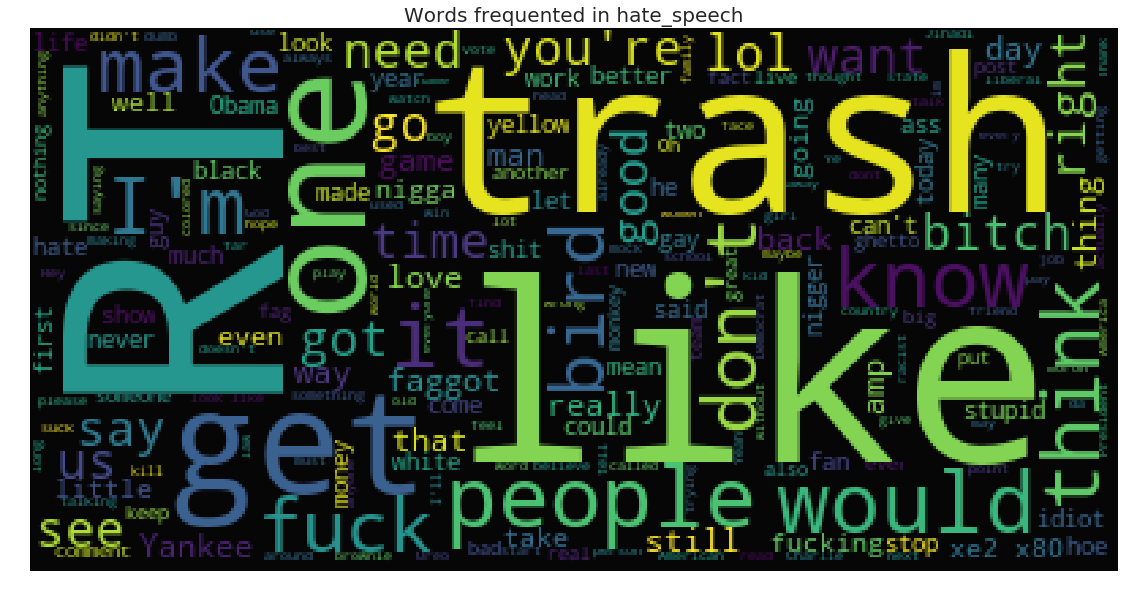

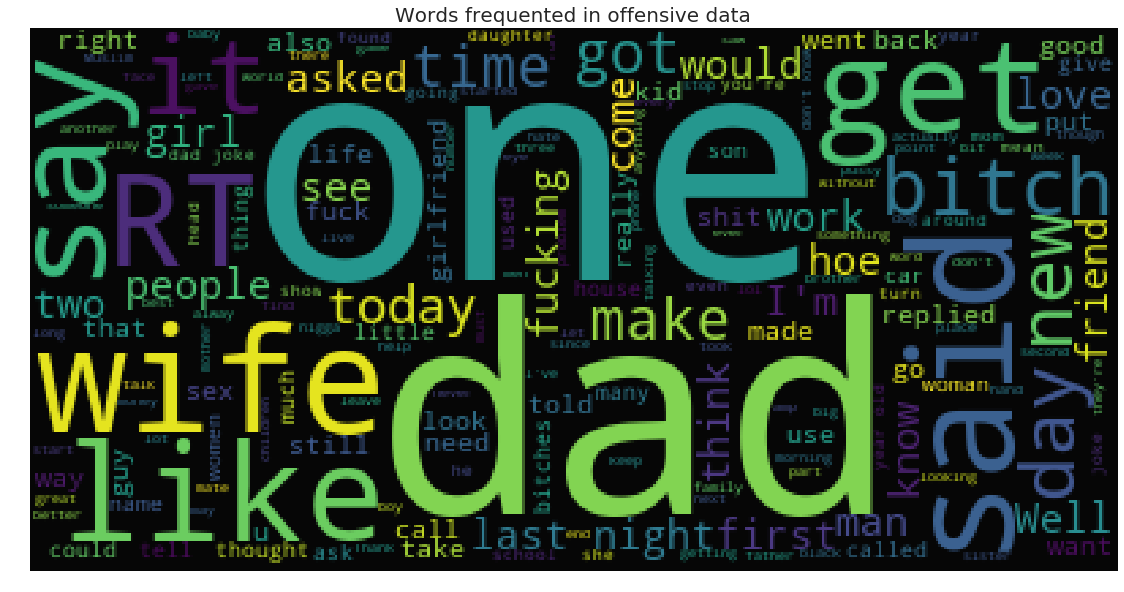

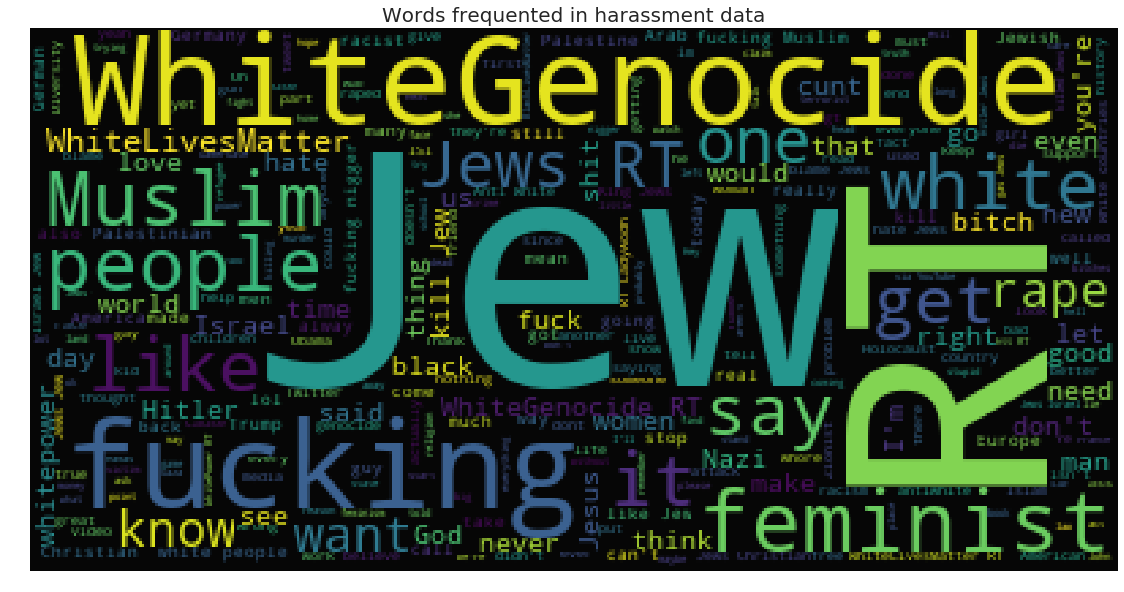

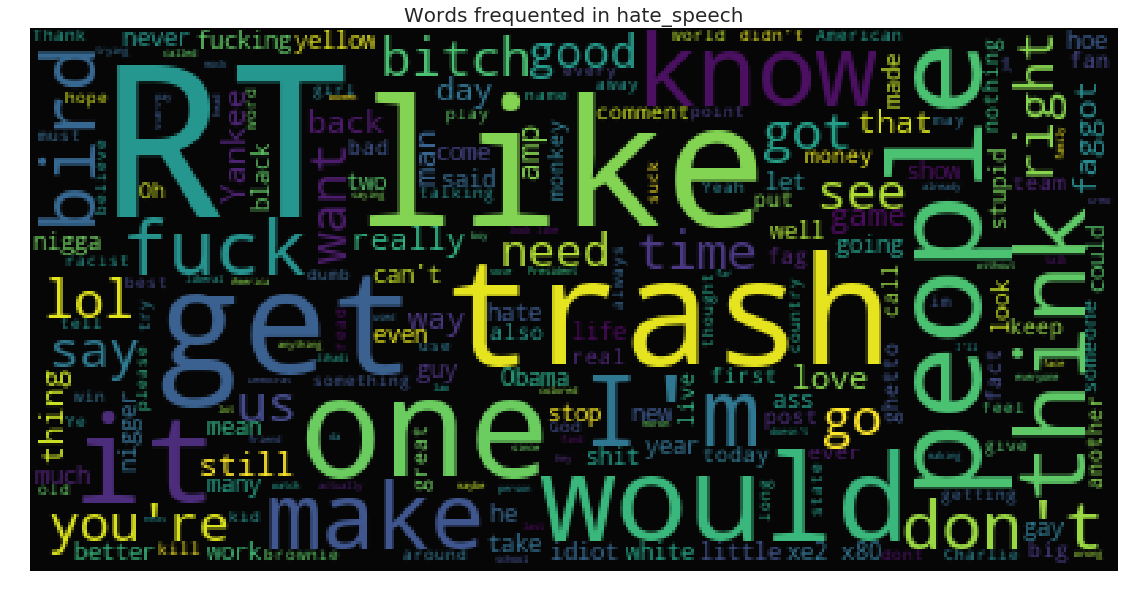

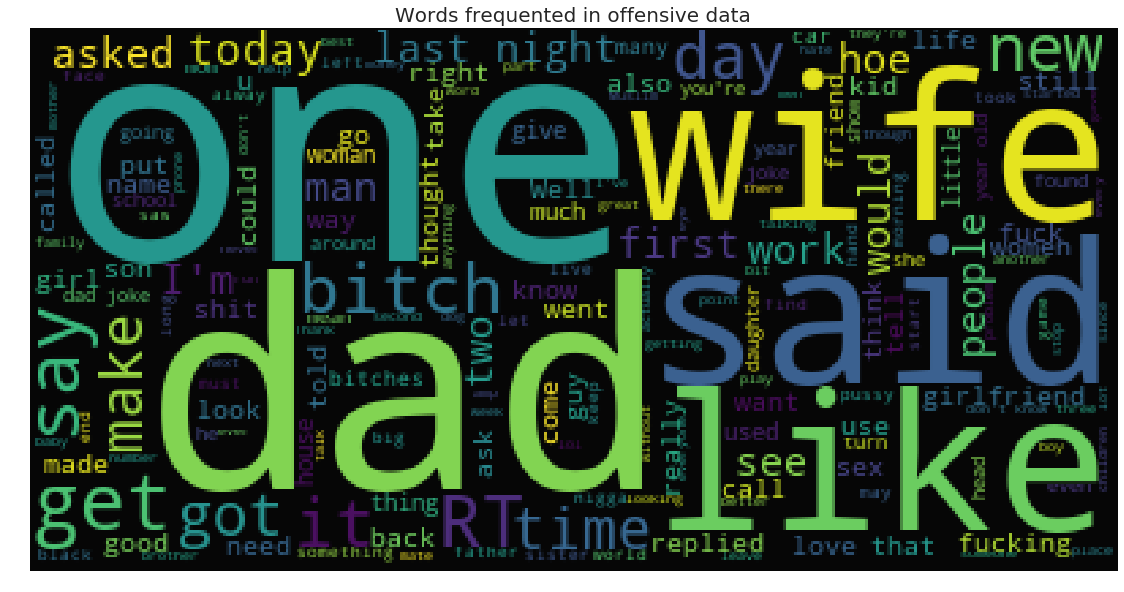

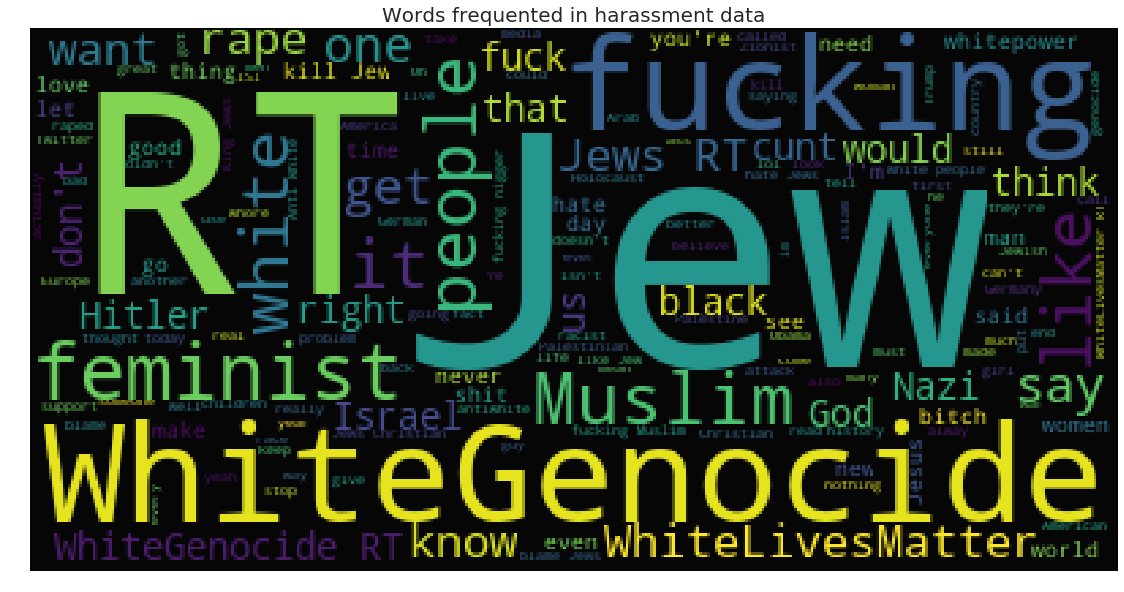

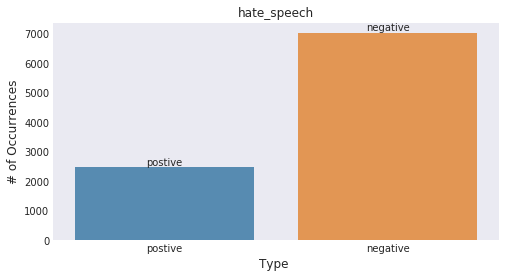

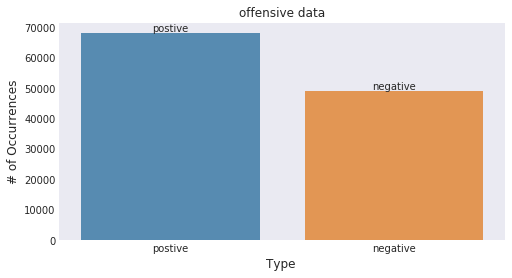

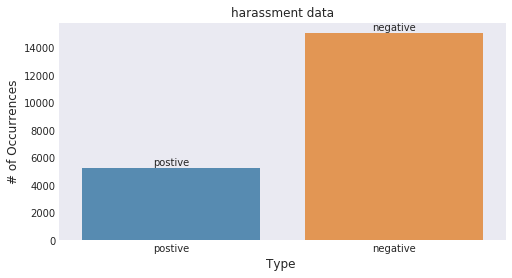

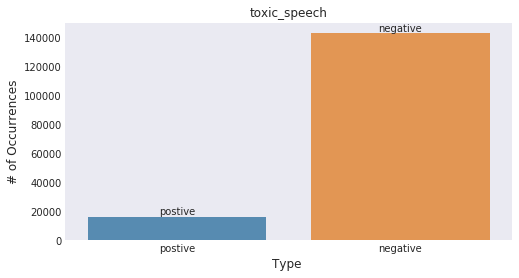

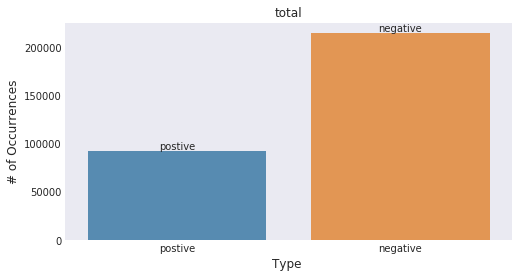

In [38]:
for k,v in datasets.items():
    x=[v['label'].sum(),len(v)-v['label'].sum()]
    
    #plot
    plt.figure(figsize=(8,4))
    ax= sns.barplot(['postive','negative'], x, alpha=0.8)
    plt.title(k)
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('Type ', fontsize=12)
    #adding the text labels
    rects = ax.patches
    labels = ['postive','negative']
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

hate_speech
offensive data
harassment data
toxic_speech
total


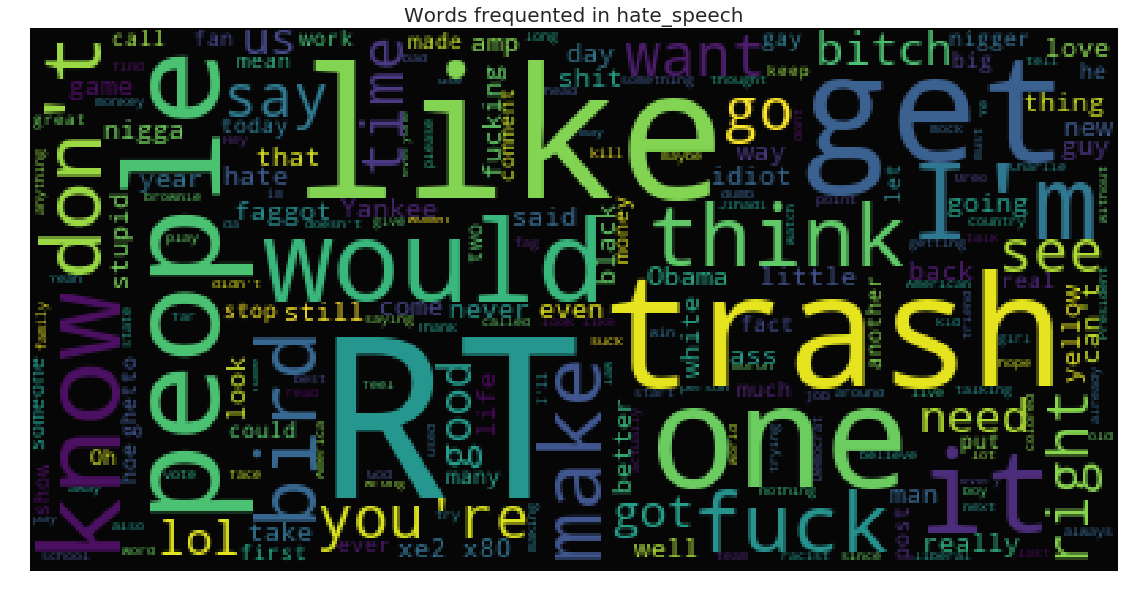

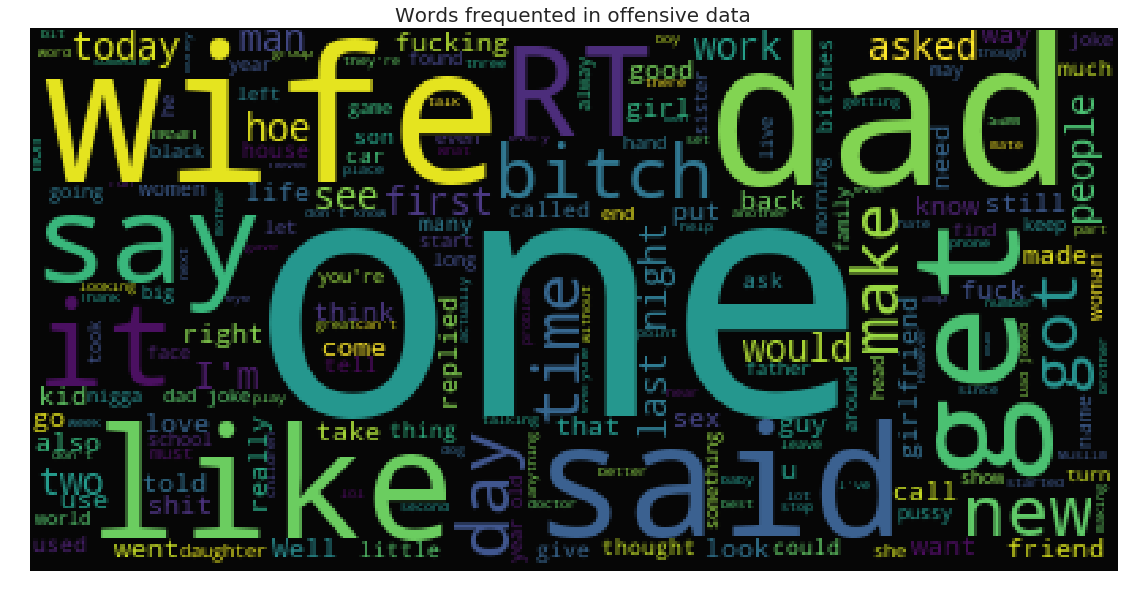

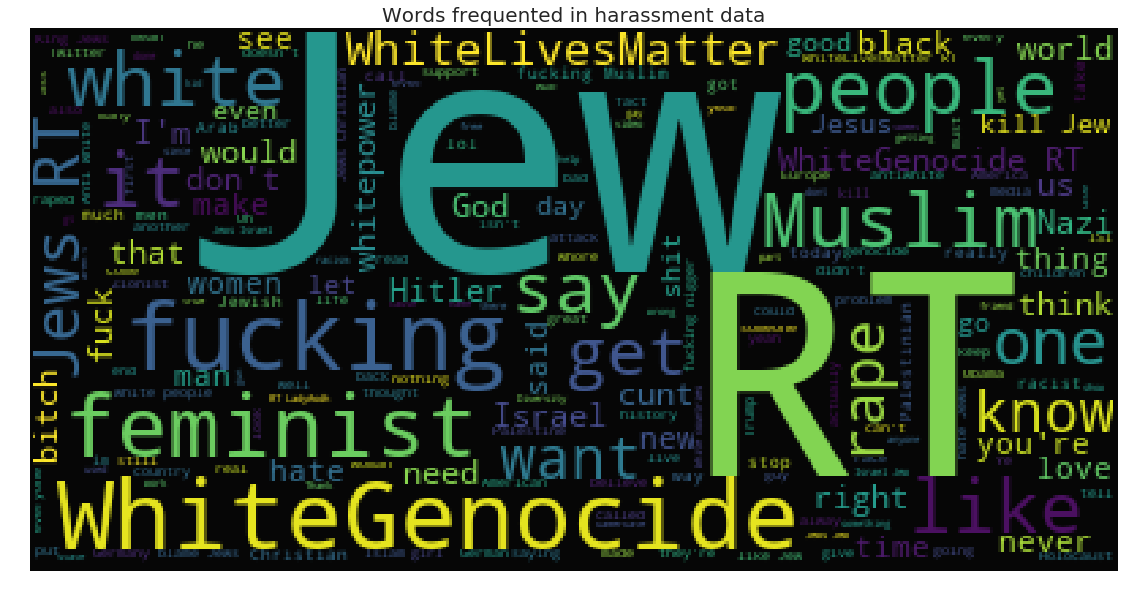

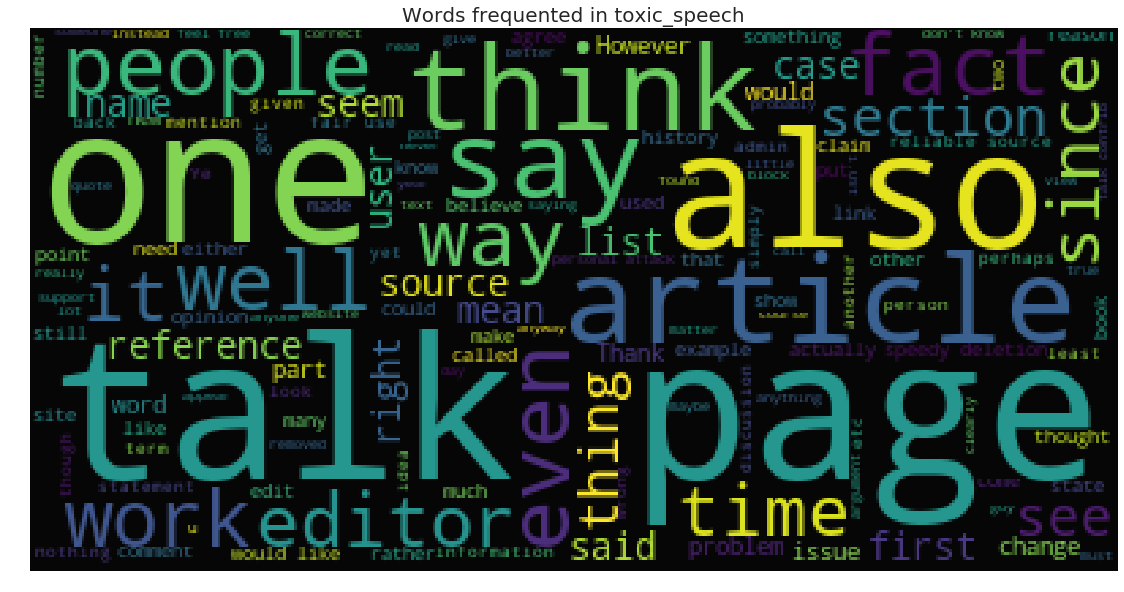

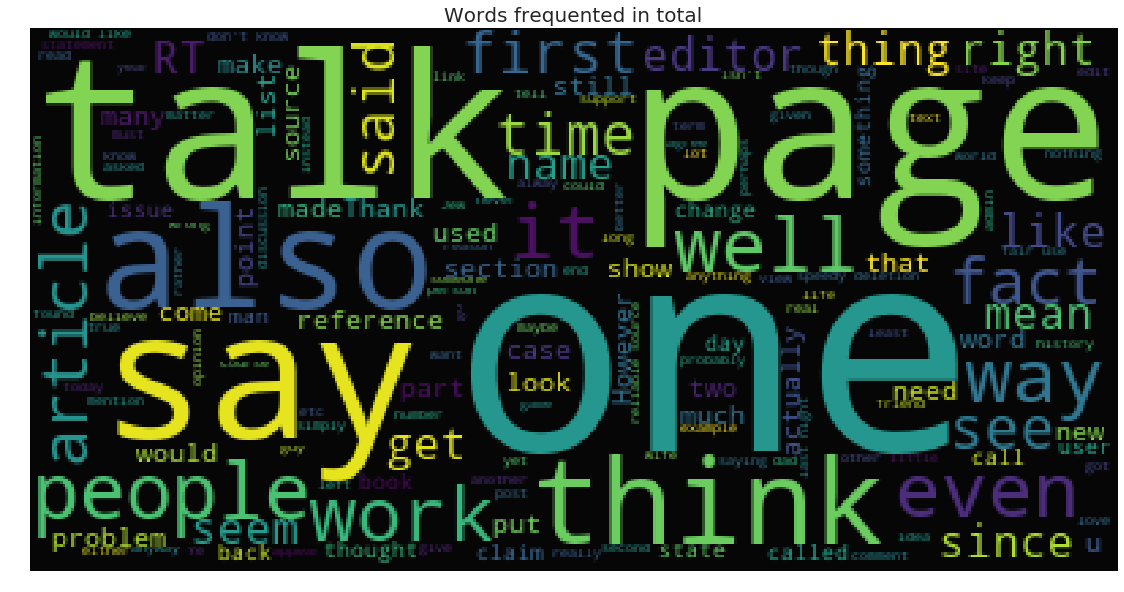

In [39]:
for k,v in datasets.items():
    print(k)
    v['text']=[' '.join([f for f in str(t).split(' ') if not f.startswith('http')]) for t in v['text']]
        
    
    text=' '.join(v['text'])
    wc= WordCloud(background_color="black",max_words=200,stopwords=st_words)
    wc.generate(text)
    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.title("Words frequented in " + k, fontsize=20)
    plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [47]:
df = datasets.get('total')
df['count_sent']=df["text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["text"].apply(lambda x: len(str(x).split(' ')))
#Unique word count
df['count_unique_word']=df["text"].apply(lambda x: len(set(str(x).split(' '))))
#Letter count
df['count_letters']=df["text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split(' ') if w in st_words]))
#Average length of the words
df["mean_word_len"] = df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(' ')]))

/home/striker/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


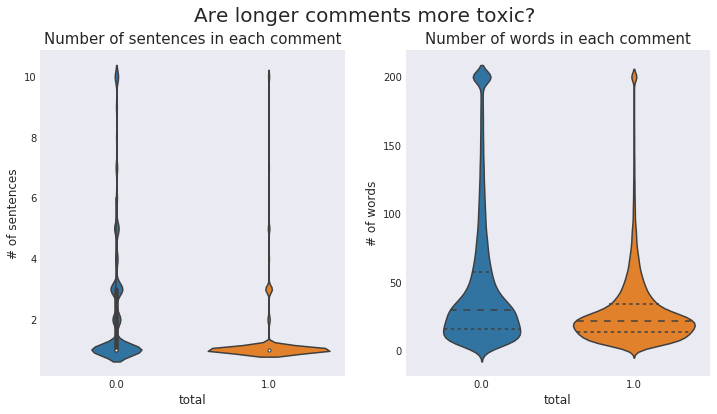

In [55]:
df['count_sent'].loc[df['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='label', data=df, split=True)

plt.xlabel('total', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
df['count_word'].loc[df['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='label', data=df,split=True,inner="quart")

plt.xlabel('total', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [59]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer())])

text_clf.fit(df['text'], df['label'])



Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))])

In [61]:
text_clf.named_steps['tfidf'].

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [53]:
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)


NameError: name 'train_unigrams' is not defined

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()